# Model tuning function
The objective of this notebook is to evaluate different algorithms for finding the optimal l1 regularization factor for the Autoplier Package for a given Dataset. 

The l1 regularization factor is crucial for controlling the sparsity of the encoder layer. Encoder layer sparsity is important to make the latent variables interpretable as combinations of pathways. A higher l1 regularization factor usually corresponds to a sparser layer.

## Function used for evaluating sparsity

Sparsity of the encoder layer is evaluated using a measure called epsilon sparsity. The metric is defined as the number of elements within an epsilon interval of 0 divided by the total number of elements. This is implemented in the function sparsity_epsilon with Z being the encoder layer and epsilon the epsilon value. For these analyses an epsilon value of 10**-4 was used.
The epsilon sparsity was used as a measure, because weights in our model would be set to close to zero but not exactly to zero.

In [1]:
def sparsity_epsilon(Z, epsilon):
    s = (np.sum((np.abs(Z) < epsilon).astype(int)).sum()) / float(Z.size)
    return s

# Data

In [2]:
# Imports
from autoplier.model import set_seed_
import autoplier.model as ap
from bayes_opt import BayesianOptimization
import csv
import json
from matplotlib import pyplot as plt
import numpy as np
from onto_lib import general_ontology_tools as got
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
import time
import warnings

Unable to import pygraphviz. Visualization is disabled.
Loading ontology from C:\Users\julia\anaconda3\envs\autopliernotebook\lib\site-packages\onto_lib\obo\DOID.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\envs\autopliernotebook\lib\site-packages\onto_lib\obo\UBERON.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\envs\autopliernotebook\lib\site-packages\onto_lib\obo\CL.18-11-13.obo ...
Loading ontology from C:\Users\julia\anaconda3\envs\autopliernotebook\lib\site-packages\onto_lib\obo\CVCL.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\envs\autopliernotebook\lib\site-packages\onto_lib\obo\EFO.17-01-30.obo ...


## Pathways used
Msigdb canonical pathways release 7.4 (Gene symbols) was used as the pathways database. This database contains 2922 Pathways and 13351 gene symbols.

In [3]:
pathway_genes = []
pathway_names = []

with open('c2.cp.v7.4.symbols.gmt', newline='\n') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        pathway_names += [row[0]]
        pathway_genes += [row[2:]]

In [4]:
mlb = MultiLabelBinarizer()
pathways = pd.DataFrame(mlb.fit_transform(pathway_genes), index = pathway_names, columns = mlb.classes_)

In [5]:
pathways

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZSCAN25,ZSCAN32,ZSCAN4,ZSWIM8,ZW10,ZWILCH,ZWINT,ZYG11B,ZYX,ZZZ3
BIOCARTA_GRANULOCYTES_PATHWAY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BIOCARTA_LYM_PATHWAY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BIOCARTA_BLYMPHOCYTE_PATHWAY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BIOCARTA_CARM_ER_PATHWAY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BIOCARTA_LAIR_PATHWAY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
REACTOME_KINESINS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
REACTOME_FACTORS_INVOLVED_IN_MEGAKARYOCYTE_DEVELOPMENT_AND_PLATELET_PRODUCTION,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
REACTOME_ANTIGEN_ACTIVATES_B_CELL_RECEPTOR_BCR_LEADING_TO_GENERATION_OF_SECOND_MESSENGERS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data used for evaluation
The following functions are evaluated on the CellO Dataset of RNA seq data of healthy celltypes. This Matrix is called X in the code. 

In [6]:
rnaseq = pd.read_csv("mat4.csv",index_col = 0).T

In [7]:
# train test split
with open('validation_bulk_experiments.json', 'r') as f:
    validation_egs = json.load(f)

with open('pre_training_bulk_experiments.json', 'r') as f:
    train_egs = json.load(f)

In [8]:
X_train = rnaseq[rnaseq.index.isin(train_egs)]
X_validate = rnaseq[rnaseq.index.isin(validation_egs)]

In [9]:
with open("bulk_labels.json", 'r') as f:
    labels = json.load(f)

In [10]:
sample2types_full = {
        sample: list(map(got.get_term_name, types_ids))
        for sample, types_ids in labels.items()
    }

In [11]:
mlb_full = MultiLabelBinarizer()

types_per_samples = rnaseq.index.map(sample2types_full).values
samples_dummies = pd.DataFrame(mlb_full.fit_transform(types_per_samples), columns=mlb_full.classes_,
                                      index=rnaseq.index)

celltypes = samples_dummies.columns.tolist()

type2samples = {
    type_: samples_dummies.index[samples_dummies[type_] == 1].tolist()
    for type_ in celltypes
}

In [12]:
# fscore metric used to evaluate classifiers
def fscore(p, r):
    denom = p + r or 1

    return 2*(p * r) / denom

In [13]:
types_sizes = samples_dummies.sum()
types_with_data = types_sizes.index.values
all_types = samples_dummies.columns

In [14]:
# Autoplier callbacks
callbacks = [
        #early stopping - to mitigate overfitting
        EarlyStopping(patience=100, monitor='val_loss'),
        #monitor umatrix sparsity
        ]

## Sparsity and conservation of biological information in the embedding
The relationship of sparsity and the conservation of biological information in the embedding was investigated. The classification performance of logistic regression classifiers trained on the embeddings was evaluated using the labels of the CellO dataset. This classification performance ( Average Precision) was used as a proxy for the conservation of biological information in the embedding. This experiment was repeated 10 times with different seeds.

In [21]:
warnings.filterwarnings('ignore') 

space = np.linspace(0, 1, num=10)**10


AP_full = []
sparse_full = []
ap_dfs = []
s_dfs = []

AP_s = []
s_S = []
for k in range(0,10):
        ap.set_seed(k)
        APs = []
        sparsities = []
        for i in space:

            successful_celltypes = []
            unsuccessful_celltypes = []
            test_prs_AP = []
            test_precision_AP = []
            test_recall_AP = []
            fscores_AP = []
            aps_AP = []
            mod = ap.autoPLIER(100, regval = i)
            mod.fit(X_train, pathways, verbose=0, batch_size = len(X_train))
            train_data_AP = mod.transform(X_train, pathways)
            test_data_AP = mod.transform(X_validate, pathways)

            train_target_full = samples_dummies[samples_dummies.index.isin(train_data_AP.index)]
            test_target_full = samples_dummies[samples_dummies.index.isin(test_data_AP.index)]

            for cell_type in all_types:

                train_target = train_target_full[cell_type]
                test_target = test_target_full[cell_type]

                if(1 in train_target.values and 1 in test_target.values and 0 in train_target.values and 0 in test_target.values):
                    # lasso penalty

                    clf_AP = LogisticRegression(solver = "liblinear",penalty = "l2",random_state=111, max_iter = 1000)

                    clf_AP.fit(train_data_AP, train_target)
                    target_pred_AP = clf_AP.predict(test_data_AP)
                    target_probs_AP = clf_AP.predict_proba(test_data_AP)[:,1]
                    test_pr_AP = average_precision_score(test_target, target_probs_AP)
                    test_precision_AP += [precision_score(test_target, target_pred_AP)]
                    test_recall_AP += [recall_score(test_target, target_pred_AP)]
                    aps_AP += [average_precision_score(test_target, target_probs_AP)]
                    fscores_AP += [fscore(test_precision_AP[-1], test_recall_AP[-1])]

                    successful_celltypes += [cell_type]
                else:
                    unsuccessful_celltypes += [cell_type]

            p_AP = np.mean(test_precision_AP)
            r_AP = np.mean(test_recall_AP)
            f_AP = np.mean(fscores_AP)
            f_micro_AP = fscore(p_AP, r_AP) 
            ap_AP = np.mean(aps_AP)

            Z = mod.transform(X_validate, pathways)
            APs += [ap_AP]
            sparsities += [sparsity_epsilon(mod.components_decomposition_, 10**-4)]
        AP_s += [APs]
        s_S += [sparsities]
ap_df = pd.DataFrame.from_records(AP_s)
s_df = pd.DataFrame.from_records(s_S)
    
AP_mean = ap_df.mean()
sparse_mean = s_df.mean()

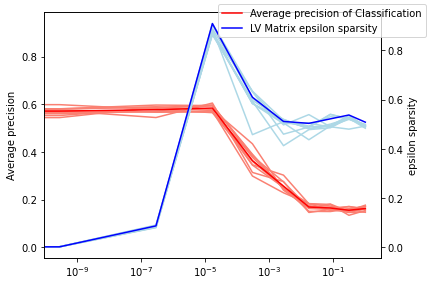

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

exp = lambda x: 10**(x)
log = lambda x: np.log(x)

for j in range(0,len(ap_df[i])):
    ax1.plot(space,ap_df.T[j], c='salmon')
    
ax1.plot(space,AP_mean, c='r', label='Average precision of Classification')
ax1.set_ylabel('Average precision')
ax1.set_xscale('log')

ax2 = ax1.twinx()
for j in range(0,len(ap_df[i])):
    ax1.plot(space,s_df.T[j], c='lightblue')
    
ax2.plot(space, sparse_mean, c='b', label="LV Matrix epsilon sparsity")
ax2.set_ylabel('epsilon sparsity')

fig.legend(loc='upper right');
plt.xlabel("regval")

fig.tight_layout()
plt.show()

In [31]:
def train_logistic_regression_classifiers(l1):
    warnings.filterwarnings('ignore') 
    ap.set_seed(111)
    APs = []
    sparsities = []
    successful_celltypes = []
    unsuccessful_celltypes = []
    test_prs_AP = []
    test_precision_AP = []
    test_recall_AP = []
    fscores_AP = []
    aps_AP = []
    mod = ap.autoPLIER(100, regval = l1)
    mod.fit(X_train, pathways, verbose=0, batch_size = len(X_train))
    train_data_AP = mod.transform(X_train, pathways)
    test_data_AP = mod.transform(X_validate, pathways)

    train_target_full = samples_dummies[samples_dummies.index.isin(train_data_AP.index)]
    test_target_full = samples_dummies[samples_dummies.index.isin(test_data_AP.index)]

    for cell_type in all_types:

        train_target = train_target_full[cell_type]
        test_target = test_target_full[cell_type]

        if(1 in train_target.values and 1 in test_target.values and 0 in train_target.values and 0 in test_target.values):
            # lasso penalty

            clf_AP = LogisticRegression(solver = "liblinear",penalty = "l2",random_state=111, max_iter = 1000)

            clf_AP.fit(train_data_AP, train_target)
            target_pred_AP = clf_AP.predict(test_data_AP)
            target_probs_AP = clf_AP.predict_proba(test_data_AP)[:,1]
            test_pr_AP = average_precision_score(test_target, target_probs_AP)
            test_precision_AP += [precision_score(test_target, target_pred_AP)]
            test_recall_AP += [recall_score(test_target, target_pred_AP)]
            aps_AP += [average_precision_score(test_target, target_probs_AP)]
            fscores_AP += [fscore(test_precision_AP[-1], test_recall_AP[-1])]

            successful_celltypes += [cell_type]
        else:
            unsuccessful_celltypes += [cell_type]

        p_AP = np.mean(test_precision_AP)
        r_AP = np.mean(test_recall_AP)
        f_AP = np.mean(fscores_AP)
        f_micro_AP = fscore(p_AP, r_AP) 
        ap_AP = np.mean(aps_AP)
        
        df = pd.DataFrame([aps_AP], columns = successful_celltypes)
    return(df.T)

## Optimization function evaluation

The evaluation will take code execution time into account, aswell as conservation of biologically relevance of the generated embedding. Two functions are evaluated, Bayesian optimization, as implemented in the package BayesianOptimization, aswell as a modified Grid search. As can be seen from the above plot, up to a certain l1 regularization value biological information is mostly retained. This makes smaller l1 values more suitable to be used.

In [34]:
def tune_bayes(l1):
    set_seed_(111)
    target = 0.7
    mod = ap.autoPLIER(100, regval = l1)
    mod.fit(X_train, pathways, callbacks, batch_size= len(X_train), maxepoch=2000, verbose=0, valfrac=.3)
    
    sparse = - abs(target -sparsity_epsilon(mod.components_decomposition_, 10**-4))
    return sparse

In [35]:
# Bounded region of parameter space
pbounds = {'l1': (0, 0.1)}

optimizer = BayesianOptimization(
    f=tune_bayes,
    pbounds=pbounds,
    random_state=111,
)

In [36]:

start_time = time.time()
optimizer.maximize(
    init_points=10,
    n_iter=7,
)
(time.time() - start_time) / 60

|   iter    |  target   |    l1     |
-------------------------------------
|  1        | -0.2239   |  0.06122  |
|  2        | -0.2272   |  0.01691  |
|  3        | -0.226    |  0.04361  |
|  4        | -0.219    |  0.07693  |
|  5        | -0.2288   |  0.02953  |
|  6        | -0.2276   |  0.01492  |
|  7        | -0.1334   |  0.002248 |
|  8        | -0.2245   |  0.04202  |
|  9        | -0.2365   |  0.02387  |
|  10       | -0.237    |  0.03377  |
|  11       | -0.6977   |  0.0      |
|  12       | -0.0646   |  0.002684 |
|  13       | -0.1185   |  0.004052 |
|  14       | -0.1758   |  0.006795 |
|  15       | -0.2077   |  0.009389 |
|  16       | -0.04546  |  0.002741 |
|  17       | -0.06424  |  0.003341 |


13.77528334458669

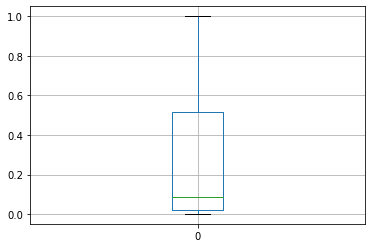

In [37]:
ap_df = train_logistic_regression_classifiers(0.002741)
ap_df.boxplot()
plt.show()

In [38]:
def optimize_sparsity(target_sparsity, delta):
    set_seed_(111)
    sparsity = 0
    l1 = 10**-9
    step = 10
    closest = 1
    closest_l1 = l1
    while(abs(sparsity- target_sparsity) > delta):
        
        mod = ap.autoPLIER(100, regval = l1)
        mod.fit(X_train, pathways, callbacks, batch_size= len(X_train), maxepoch=2000, verbose=0, valfrac=.3)
        sparsity = sparsity_epsilon(mod.components_decomposition_, 10**-4)
        diff = sparsity- target_sparsity
        
        if( abs(diff) < closest and diff < 0):
            closest = abs(diff)
            closest_l1 = l1
            if( abs(diff) > delta):
                l1 = l1 * step
            
        else:
            
            if(diff >0):
                step = step /2
                l1 = closest_l1 * step
            else:
                l1 = closest_l1 / step
                step = step /2
                l1 = l1 * step
        print(closest_l1)
        print(sparsity)
    return closest_l1

In [39]:
start_time = time.time()
l1 = optimize_sparsity(0.7,0.1)
(time.time() - start_time) / 60

1e-09
0.0024469541409993154
1e-08
0.0027378507871321013
1e-07
0.012854209445585216
1e-06
0.41720396988364133
1e-06
0.8556262833675564
1e-06
0.8752532511978097
1e-06
0.7774674880219028


17.060583317279814

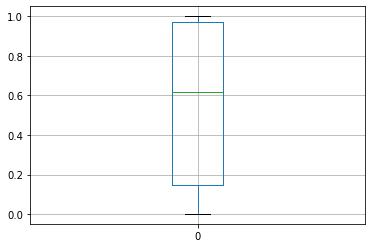

In [40]:
ap_df = train_logistic_regression_classifiers(l1)
ap_df.boxplot()
plt.show()

In [41]:
l1

1e-06